# BÀI TẬP VỀ NHÀ:
Thử lập trình mô hình đề xuất trong bài báo dưới đây cho bài toán nhận diện cảm xúc: https://www.researchgate.net/profile/Dinh_Sang/publication/321257241_Facial_expression_recognition_using_deep_convolutional_neural_networks/links/5b12a7824585150a0a619d6c/Facial-expression-recognition-using-deep-convolutional-neural-networks.pdf


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/'My Drive'/'Colab Notebooks'/L12

/content/drive/My Drive/Colab Notebooks/L12


In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

Using TensorFlow backend.


## Reading data

Read label data then convert to one-hot encode

In [4]:
#one-hot encode for given class label
def one_hot(idx):
    y=np.zeros(7)
    y[idx]=1
    return y

data = pd.read_csv(os.path.join('Dataset','fer2013.csv'),delimiter=',',dtype='a')
Y = np.array([one_hot(int(idx)) for idx in data['emotion']],np.float)
print(Y.shape)
print(Y)

(35887, 7)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


Read sample data using pandas, then reshape to (48,48,1)

In [5]:
imagebuffer=np.array(data['pixels'])
print(imagebuffer.shape)
one_channel_X = np.array([np.fromstring(image,np.uint8,sep=' ').reshape((48,48,1)) for image in imagebuffer],np.float)
print(one_channel_X[0])
X=np.repeat(one_channel_X, 3, -1)
del imagebuffer
print(X.shape)
print(X[0])

(35887,)
[[[ 70.]
  [ 80.]
  [ 82.]
  ...
  [ 52.]
  [ 43.]
  [ 41.]]

 [[ 65.]
  [ 61.]
  [ 58.]
  ...
  [ 56.]
  [ 52.]
  [ 44.]]

 [[ 50.]
  [ 43.]
  [ 54.]
  ...
  [ 49.]
  [ 56.]
  [ 47.]]

 ...

 [[ 91.]
  [ 65.]
  [ 42.]
  ...
  [ 72.]
  [ 56.]
  [ 43.]]

 [[ 77.]
  [ 82.]
  [ 79.]
  ...
  [105.]
  [ 70.]
  [ 46.]]

 [[ 77.]
  [ 72.]
  [ 84.]
  ...
  [106.]
  [109.]
  [ 82.]]]
(35887, 48, 48, 3)
[[[ 70.  70.  70.]
  [ 80.  80.  80.]
  [ 82.  82.  82.]
  ...
  [ 52.  52.  52.]
  [ 43.  43.  43.]
  [ 41.  41.  41.]]

 [[ 65.  65.  65.]
  [ 61.  61.  61.]
  [ 58.  58.  58.]
  ...
  [ 56.  56.  56.]
  [ 52.  52.  52.]
  [ 44.  44.  44.]]

 [[ 50.  50.  50.]
  [ 43.  43.  43.]
  [ 54.  54.  54.]
  ...
  [ 49.  49.  49.]
  [ 56.  56.  56.]
  [ 47.  47.  47.]]

 ...

 [[ 91.  91.  91.]
  [ 65.  65.  65.]
  [ 42.  42.  42.]
  ...
  [ 72.  72.  72.]
  [ 56.  56.  56.]
  [ 43.  43.  43.]]

 [[ 77.  77.  77.]
  [ 82.  82.  82.]
  [ 79.  79.  79.]
  ...
  [105. 105. 105.]
  [ 70.  70.  70.]

Training and testing split
Can use the 3rd column of the .csv file to indicate the usage, but for simpler and faster, split data set just by indexing.   
The first 28709 samples for training set, the next 3589 ones for the public test set, and the rest 3589 for the private test set.

In [6]:
x_train=X[:28709]/255
y_train=Y[:28709]
x_val=X[28709:32298]/255
y_val=Y[28709:32298]
x_test=X[32298:]/255
y_test=Y[32298:]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(28709, 48, 48, 3)
(28709, 7)
(3589, 48, 48, 3)
(3589, 7)
(3589, 48, 48, 3)
(3589, 7)


In the preprocessing data stage, I found that there was some noisy data in the training set, that could affect the result of the model. Each image, all the pixel is 0 as show below

In [7]:
#noise index list
noise=[]
for i in range(x_train.shape[0]):
  if x_train[i].any()==False:
    noise.append(i)
print(noise)

[6458, 7629, 10423, 11286, 13148, 13402, 13988, 15894, 22198, 22927, 28601]


[1. 0. 0. 0. 0. 0. 0.]


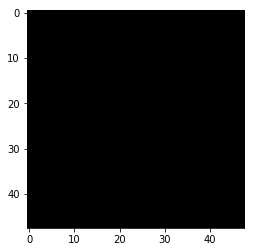

In [8]:
plt.imshow(x_train[6458].reshape(48,48,3))
print(y_train[6458])

Remove these noises

In [9]:
x_train=np.delete(x_train,noise,0)
y_train=np.delete(y_train,noise,0)
print(x_train.shape)
print(y_train.shape)

(28698, 48, 48, 3)
(28698, 7)


Split training data to training set and validation set to evaluate the model

## Contructing model


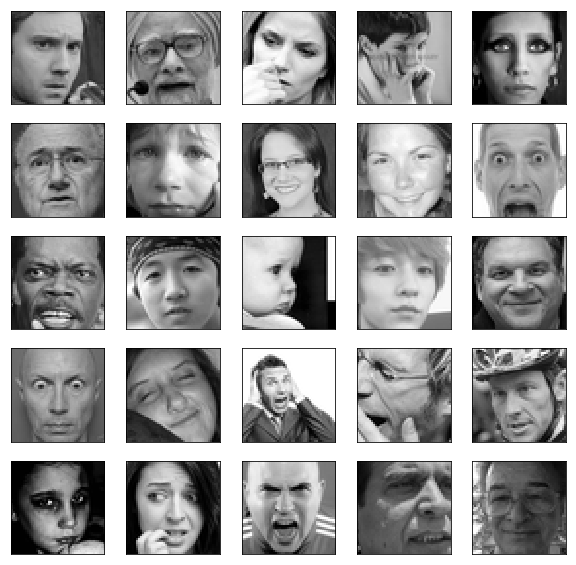

In [18]:
plt.subplots(5,5,figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train[i].reshape(48,48,3),cmap='gray')

## Fine-tune with VGG16

In [19]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
weight_decay=1e-3
num_classes=7
base_model=VGG16(include_top=False,weights='imagenet',input_shape=(48,48,3),classes=num_classes)

x=base_model.output

x = Flatten()(x)

x = Dense(units=512, activation='relu', kernel_regularizer=l2(weight_decay))(x)


x = Dense(units=512, activation='relu', kernel_regularizer=l2(weight_decay))(x)

x = Dense(units=num_classes)(x)
output=Activation('softmax')(x)

model=Model(inputs=base_model.input,outputs=output)
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

### Image augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rotation_range=20,horizontal_flip=True)
aug_gen=datagen.flow(x_train, y_train, 256,shuffle=False)

### Freeze the weights of base model and training on the fully-connected layer weights.

In [21]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

model_checkpoint=ModelCheckpoint('best_multi_svm_model.hdf5',monitor='val_acc',save_best_only=True)
reduce_lr=ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20,verbose=1)
early_stop=EarlyStopping(monitor='loss', min_delta=0, patience=50, restore_best_weights=False,verbose=1)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit_generator(aug_gen,validation_data=(x_val,y_val),steps_per_epoch=len(x_train)//256,epochs=1500, callbacks=[model_checkpoint,reduce_lr,early_stop])

Epoch 1/1500
112/112 [==============================] - 18s 159ms/step - loss: 2.1343 - acc: 0.3428 - val_loss: 1.8896 - val_acc: 0.3597
Epoch 2/1500
112/112 [==============================] - 17s 152ms/step - loss: 1.8008 - acc: 0.3728 - val_loss: 1.7640 - val_acc: 0.3787
Epoch 3/1500
112/112 [==============================] - 17s 152ms/step - loss: 1.7153 - acc: 0.3878 - val_loss: 1.7252 - val_acc: 0.3700
Epoch 4/1500
112/112 [==============================] - 17s 153ms/step - loss: 1.6770 - acc: 0.3860 - val_loss: 1.6581 - val_acc: 0.3915
Epoch 5/1500
112/112 [==============================] - 17s 154ms/step - loss: 1.6469 - acc: 0.3948 - val_loss: 1.6477 - val_acc: 0.4026
Epoch 6/1500
112/112 [==============================] - 17s 154ms/step - loss: 1.6266 - acc: 0.4020 - val_loss: 1.6344 - val_acc: 0.4062
Epoch 7/1500
112/112 [==============================] - 17s 154ms/step - loss: 1.6144 - acc: 0.4027 - val_loss: 1.6206 - val_acc: 0.4074
Epoch 8/1500
112/112 [===================

KeyboardInterrupt: ignored

In [22]:
model.evaluate(x_val,y_val)

3589/3589 [==============================] - 2s 497us/step


[1.6970228697470418, 0.4354973530272781]

### Training on all layer

In [0]:
for layer in base_model.layers:
    layer.trainable = True


In [25]:
model.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history=model.fit_generator(aug_gen,validation_data=(x_val,y_val),steps_per_epoch=len(x_train)//256,epochs=1500, callbacks=[model_checkpoint,reduce_lr,early_stop])

Epoch 1/1500
112/112 [==============================] - 28s 247ms/step - loss: 1.4173 - acc: 0.5137 - val_loss: 1.7526 - val_acc: 0.4263
Epoch 2/1500
112/112 [==============================] - 24s 213ms/step - loss: 1.3349 - acc: 0.5448 - val_loss: 1.6237 - val_acc: 0.4751
Epoch 3/1500
112/112 [==============================] - 23s 209ms/step - loss: 1.2676 - acc: 0.5751 - val_loss: 1.7181 - val_acc: 0.4308
Epoch 4/1500
112/112 [==============================] - 23s 210ms/step - loss: 1.2482 - acc: 0.5821 - val_loss: 1.6306 - val_acc: 0.4790
Epoch 5/1500
112/112 [==============================] - 24s 211ms/step - loss: 1.2165 - acc: 0.5943 - val_loss: 1.5811 - val_acc: 0.4834
Epoch 6/1500
112/112 [==============================] - 24s 211ms/step - loss: 1.2023 - acc: 0.6006 - val_loss: 1.5977 - val_acc: 0.4926
Epoch 7/1500
112/112 [==============================] - 24s 211ms/step - loss: 1.1830 - acc: 0.6083 - val_loss: 1.5680 - val_acc: 0.4909
Epoch 8/1500
112/112 [===================

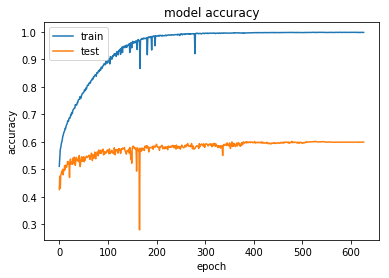

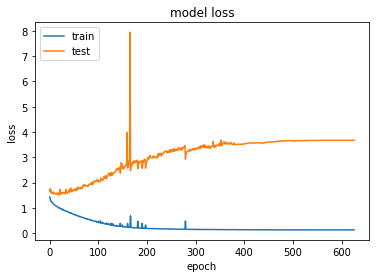

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test phase

In [32]:
model.evaluate(x_val,y_val)

3589/3589 [==============================] - 1s 417us/step


[3.6710490801766844, 0.5987740317969377]

In [34]:
model.evaluate(x_test,y_test)

3589/3589 [==============================] - 1s 417us/step


[3.455636297537112, 0.6068542769905849]